# Assignment 1

## Himanshu MDS202327

In [60]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # print(os.path.join(dirname, filename))
        pass

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import numpy, random


# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)


# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Task 1

In [62]:
# Data Loading and Relabeling
class RelabeledFashionMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.relabel_mapping = {
            0: 0,  # Clothes (T-shirt/top)
            1: 0,  # Clothes (Trouser)
            2: 0,  # Clothes (Pullover)
            3: 0,  # Clothes (Dress)
            4: 0,  # Clothes (Coat)
            5: 1,  # Shoes (Sandal)
            6: 0,  # Clothes (Shirt)
            7: 1,  # Shoes (Sneaker)
            8: 2,  # Others (Bag)
            9: 1   # Shoes (Ankle boot)
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        relabeled = self.relabel_mapping[label]
        return img, relabeled

In [63]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 3      # there are 3 classes

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Relabel datasets
train_dataset_relabel = RelabeledFashionMNIST(train_dataset)
test_dataset_relabel = RelabeledFashionMNIST(test_dataset)

train_loader = DataLoader(train_dataset_relabel, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_relabel, batch_size=64, shuffle=False)

num_classes = 3

label_dict = {0:'Clothes', 1: 'Shoes', 2:'Others'}

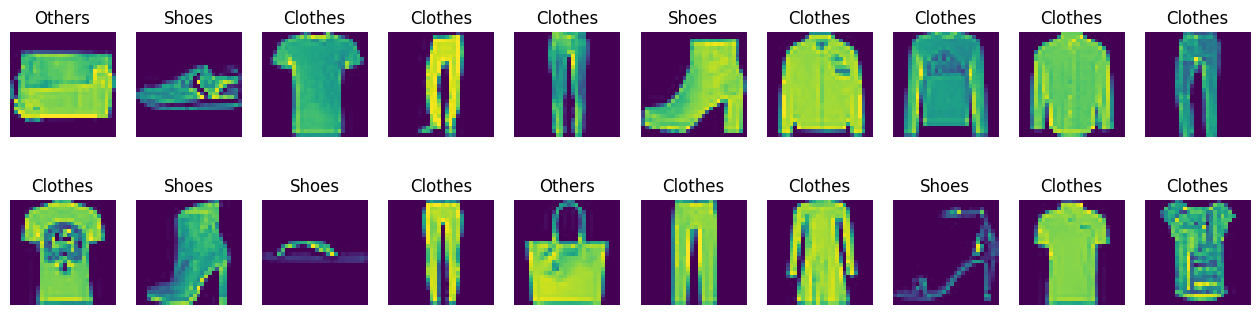

In [64]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(10,30):
    image = image_batch[i]
    label = label_dict[label_batch[i].item()]
    plt.subplot(2, 10, i + 1-10)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

#### Helper functions for training and testing


In [65]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

#### The Convolutional Network

In [66]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.fc2 = nn.Linear(200, 3)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

#### Train the Network

In [67]:
print("Training on", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on cuda:0
Number of parameters: 64595
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.102920
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.360165
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.087126
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.094223
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.123069
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.034957
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.019958
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.074480
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.054513
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.061667

Test set: Average loss: 0.0680, Accuracy: 9799/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.014027
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.101409
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.122926
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.032116
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.014969
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.043083
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.152825
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.230229
Trai

#### Show some predictions of the test network

In [68]:
def visualize_pred(img, pred_prob, real_label, label_dict, num_classes, cmap=None):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze(), cmap=cmap)
    ax1.axis('off')
    pred_label = f'Pred: {label_dict[numpy.argmax(pred_prob)]}'
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(numpy.arange(num_classes), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(num_classes))
    ax2.set_yticklabels(label_dict.values())
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

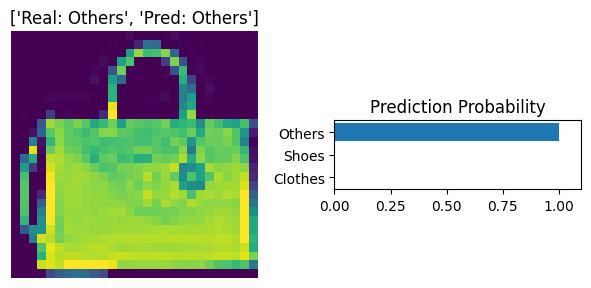

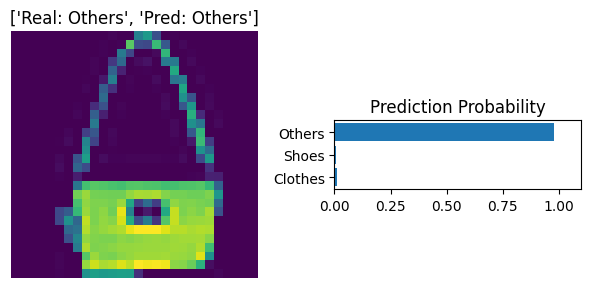

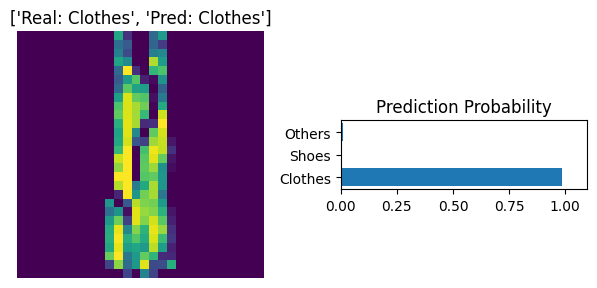

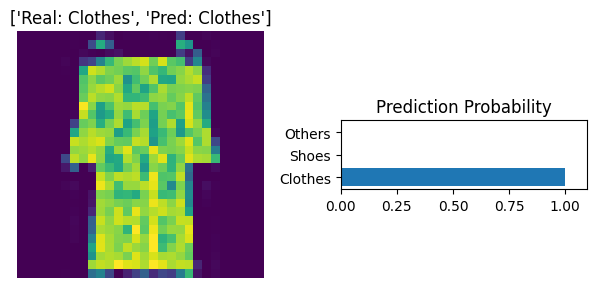

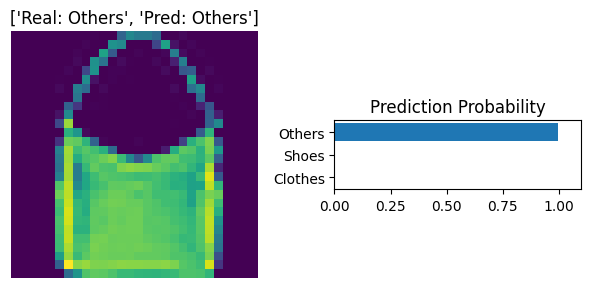

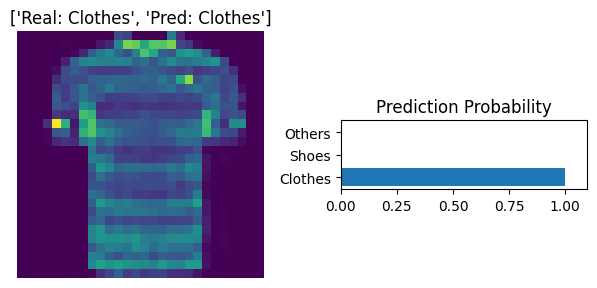

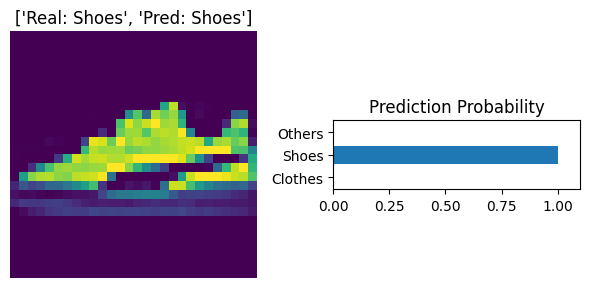

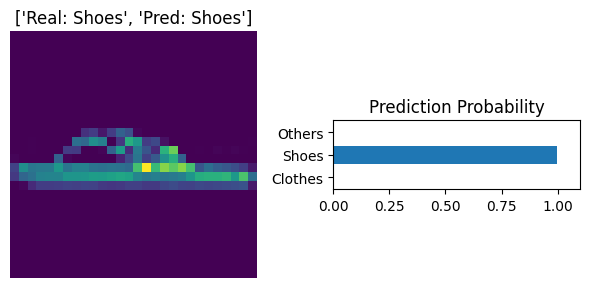

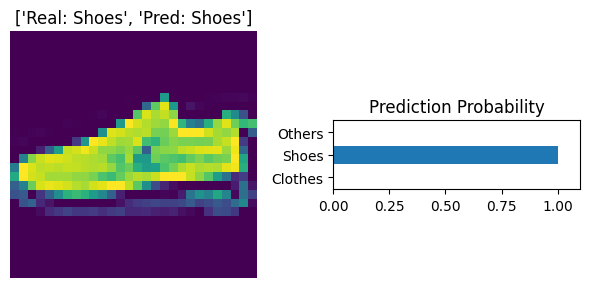

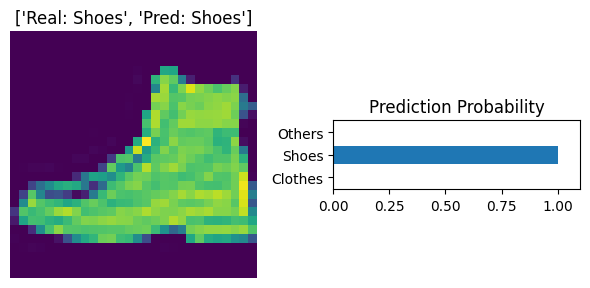

In [69]:
model_cnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)
for i in range(30,40):
    img = image_batch[i]
    real_label = f'Real: {label_dict[label_batch[i].item()]}'
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label, label_dict, num_classes)

#### Show the effect of permuting the image pixels on CNN classifiers

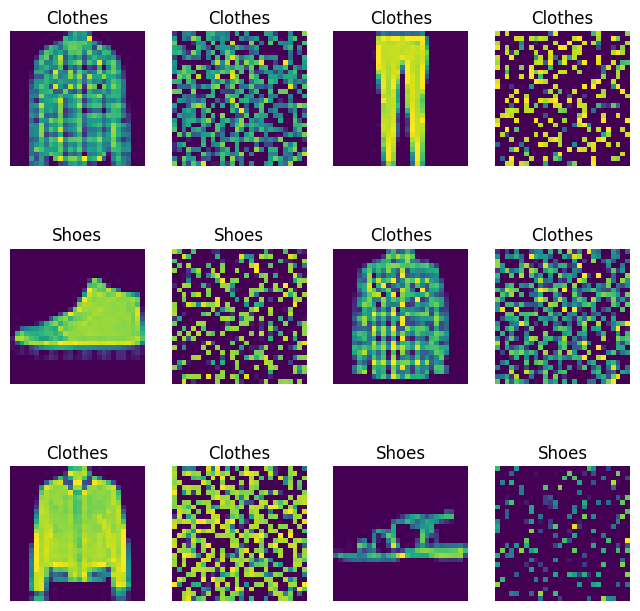

In [70]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i+24]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    label = label_dict[label_batch[i+24].item()]
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [71]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [72]:
print("Training on", device)
model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    scramble_test(model_cnn_3, fixed_perm)

Training on cuda:0
Number of parameters: 64595
Train Epoch: 1 [0/60000 (0%)]	Loss: 1.154190
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.909600
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.537502
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.244344
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.331073
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.074676
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.124117
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.053444
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.019236
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.067437

Test set: Average loss: 0.0642, Accuracy: 9805/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.029004
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.085728
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.039364
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.013994
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.029906
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.044595
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.060816
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.093175
Trai

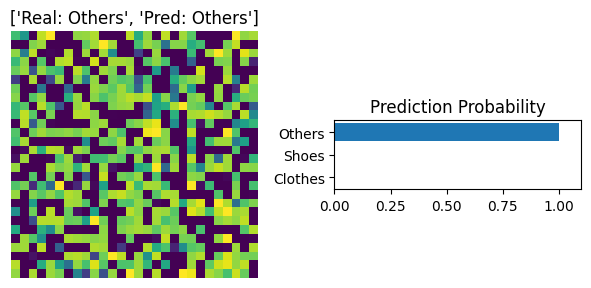

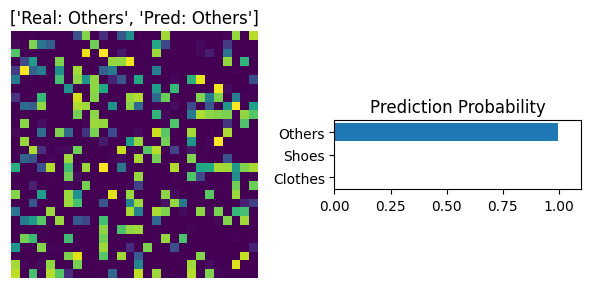

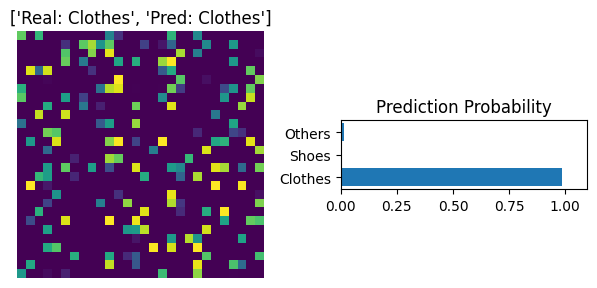

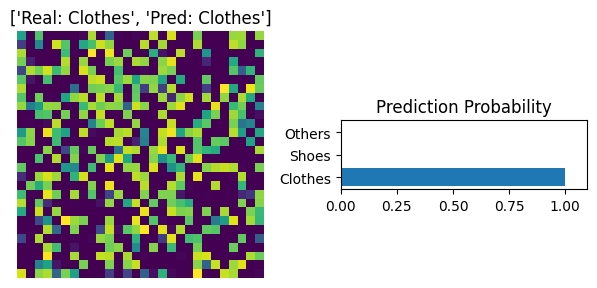

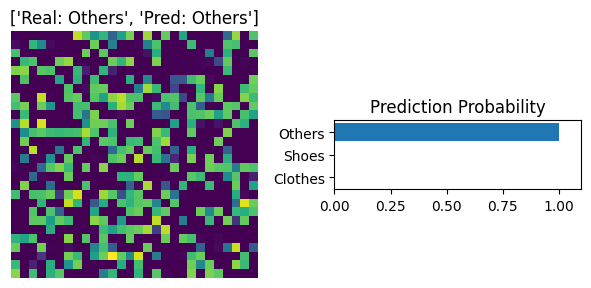

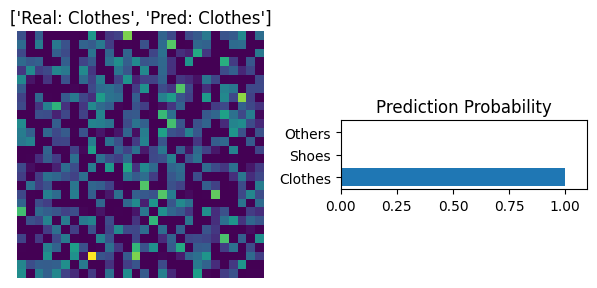

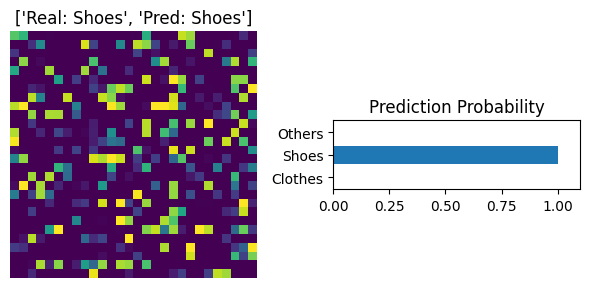

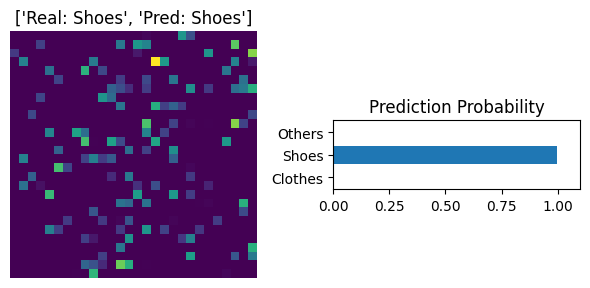

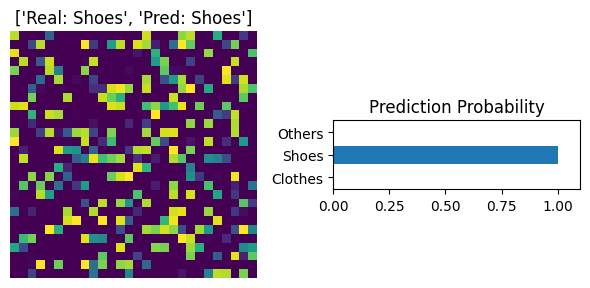

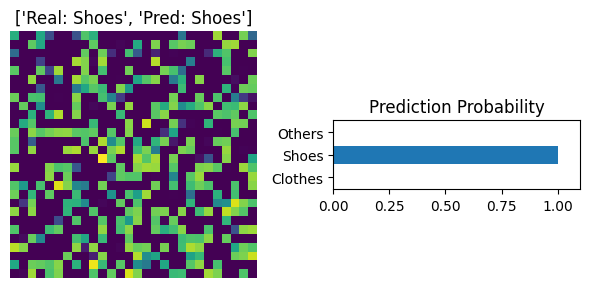

In [73]:
model_cnn_3.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)
for i in range(30,40):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = f'Real: {label_dict[label_batch[i].item()]}'
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label, label_dict, num_classes)

#### Performance slightly decreased from 99.16% to 99.14% upon scramble.

## Task 2

In [74]:
train_dir = '/kaggle/input/emotion-detection-fer/train'
test_dir = '/kaggle/input/emotion-detection-fer/test'

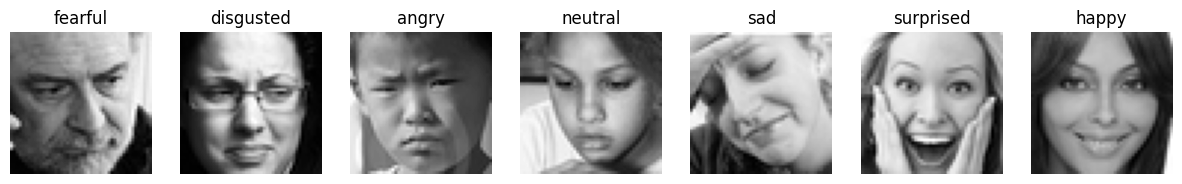

In [75]:
plt.figure(figsize=(15,10))
emotions = os.listdir(train_dir)

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(1, 7, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [76]:
# Data Preprocessing (ResNet expects 224x224 and 3 channels)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # ResNet's normalization
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

num_classes = len(train_dataset.classes)

label_dict_res = {0:'Angry', 1:'Disgusted', 2:'Fearful', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprised'}

#### ResNet-18 model from scratch

In [77]:
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(weights=None)  # From scratch
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify final layer for the number of classes

    def forward(self, x):
        return self.model(x)

#### Train the ResNet-18 model from scratch

In [78]:
print("Training on", device)
model_resnet = ResNet18(num_classes)
model_resnet.to(device)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

print('Number of parameters: {}'.format(get_n_params(model_resnet)))
print('Number of trainable parameters: {}'.format(summary(model_resnet).trainable_params))


for epoch in range(0, 10):
    train(epoch, model_resnet)
    test(model_resnet)

Training on cuda:0
Number of parameters: 11180103
Number of trainable parameters: 11180103
Train Epoch: 1 [0/28709 (0%)]	Loss: 2.103788
Train Epoch: 1 [6400/28709 (22%)]	Loss: 1.841679
Train Epoch: 1 [12800/28709 (45%)]	Loss: 1.751207
Train Epoch: 1 [19200/28709 (67%)]	Loss: 1.397599
Train Epoch: 1 [25600/28709 (89%)]	Loss: 1.568914

Test set: Average loss: 1.4381, Accuracy: 3207/7178 (45%)

Train Epoch: 2 [0/28709 (0%)]	Loss: 1.185508
Train Epoch: 2 [6400/28709 (22%)]	Loss: 1.450773
Train Epoch: 2 [12800/28709 (45%)]	Loss: 1.394580
Train Epoch: 2 [19200/28709 (67%)]	Loss: 1.032871
Train Epoch: 2 [25600/28709 (89%)]	Loss: 1.140594

Test set: Average loss: 1.2481, Accuracy: 3780/7178 (53%)

Train Epoch: 3 [0/28709 (0%)]	Loss: 1.047422
Train Epoch: 3 [6400/28709 (22%)]	Loss: 1.140004
Train Epoch: 3 [12800/28709 (45%)]	Loss: 0.874426
Train Epoch: 3 [19200/28709 (67%)]	Loss: 1.103513
Train Epoch: 3 [25600/28709 (89%)]	Loss: 1.129838

Test set: Average loss: 1.2731, Accuracy: 3843/7178 (54%

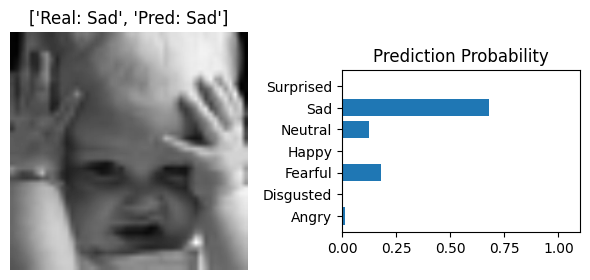

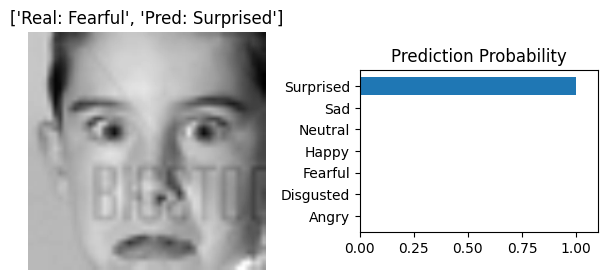

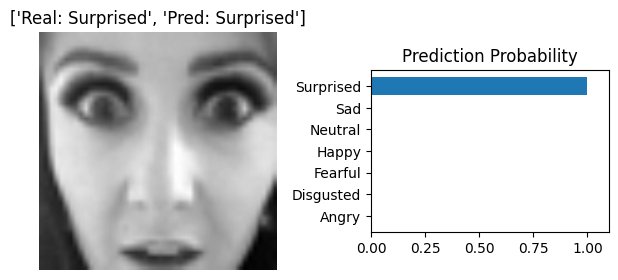

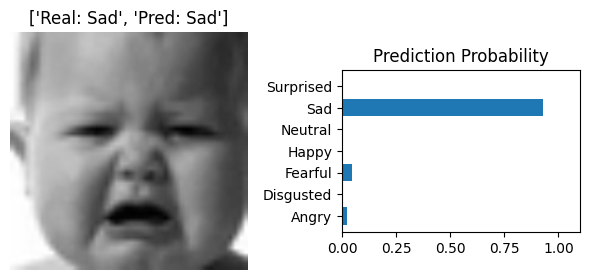

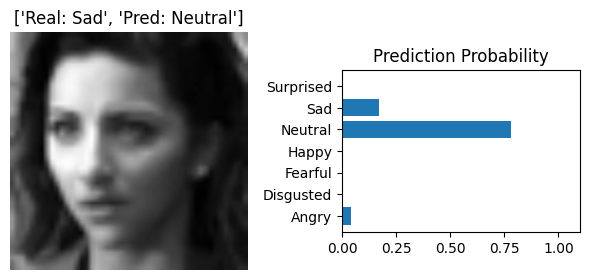

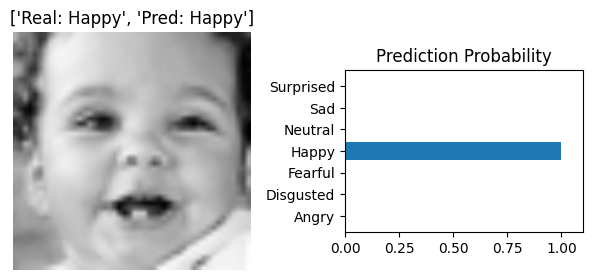

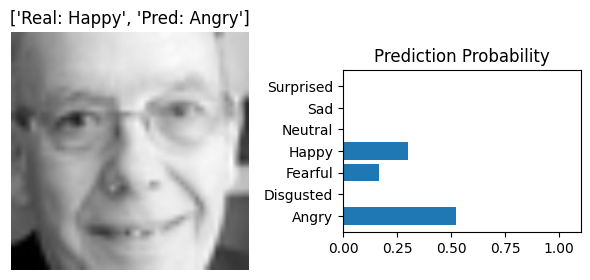

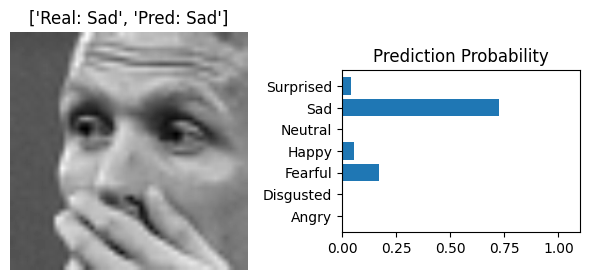

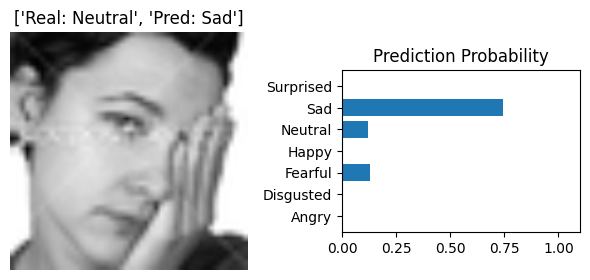

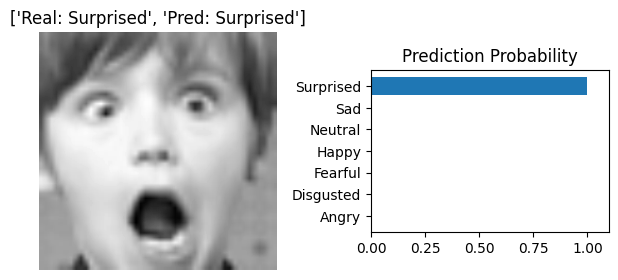

In [79]:
model_resnet.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_resnet(image_batch)
for i in range(30,40):
    img = image_batch[i][0].cpu().detach()
    real_label = f'Real: {label_dict_res[label_batch[i].item()]}'
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    pred_prob = pred_prob/sum(pred_prob)
    visualize_pred(img, pred_prob, real_label, label_dict_res, num_classes, cmap='gray')

#### Pretrained ResNet-18 model

In [83]:
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Pre-trained ResNet
        for param in self.model.parameters():
            param.requires_grad = False
            
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        for param in self.model.layer3.parameters():
            param.requires_grad = True
            
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify final layer for the number of classes

    def forward(self, x):
        return self.model(x)

In [84]:
print("Training on", device)
model_resnet_pt = PretrainedResNet18(num_classes)
model_resnet_pt.to(device) 
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
print('Number of parameters: {}'.format(get_n_params(model_resnet_pt)))
print('Number of trainable parameters: {}'.format(summary(model_resnet_pt).trainable_params))

for epoch in range(0, 10):
    train(epoch, model_resnet_pt)
    test(model_resnet_pt)

Training on cuda:0
Number of parameters: 11180103
Number of trainable parameters: 10497031
Train Epoch: 1 [0/28709 (0%)]	Loss: 2.021780
Train Epoch: 1 [6400/28709 (22%)]	Loss: 2.142139
Train Epoch: 1 [12800/28709 (45%)]	Loss: 2.175326
Train Epoch: 1 [19200/28709 (67%)]	Loss: 2.008813
Train Epoch: 1 [25600/28709 (89%)]	Loss: 2.039852

Test set: Average loss: 2.1235, Accuracy: 1070/7178 (15%)

Train Epoch: 2 [0/28709 (0%)]	Loss: 2.179924
Train Epoch: 2 [6400/28709 (22%)]	Loss: 2.099797
Train Epoch: 2 [12800/28709 (45%)]	Loss: 2.149414
Train Epoch: 2 [19200/28709 (67%)]	Loss: 2.033028
Train Epoch: 2 [25600/28709 (89%)]	Loss: 2.027916

Test set: Average loss: 2.1248, Accuracy: 1083/7178 (15%)

Train Epoch: 3 [0/28709 (0%)]	Loss: 2.184756
Train Epoch: 3 [6400/28709 (22%)]	Loss: 2.171908
Train Epoch: 3 [12800/28709 (45%)]	Loss: 2.182322
Train Epoch: 3 [19200/28709 (67%)]	Loss: 2.137072
Train Epoch: 3 [25600/28709 (89%)]	Loss: 2.103248

Test set: Average loss: 2.1218, Accuracy: 1074/7178 (15%

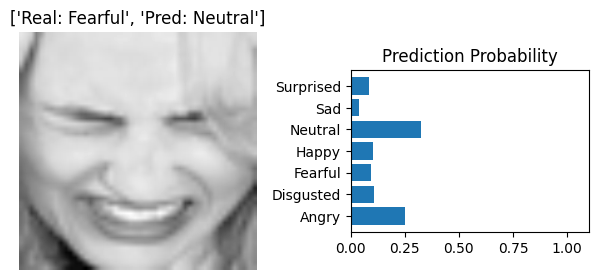

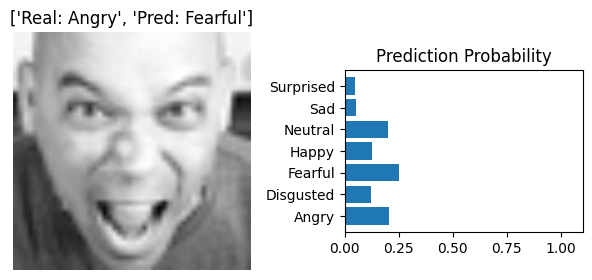

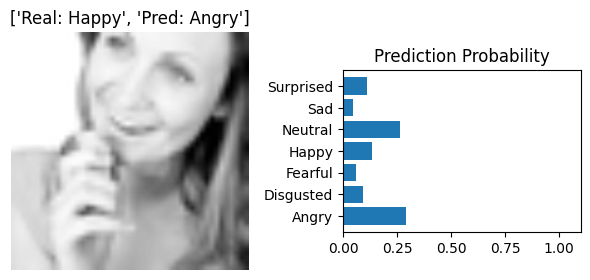

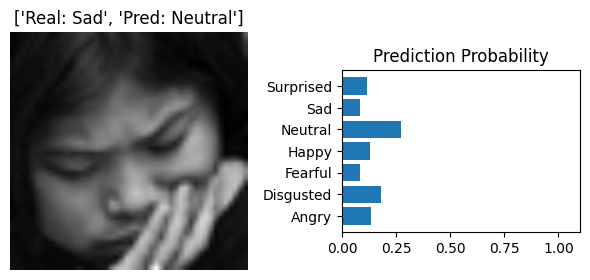

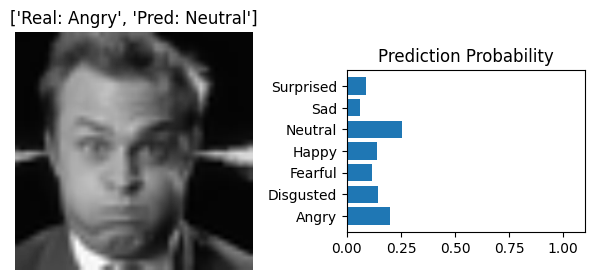

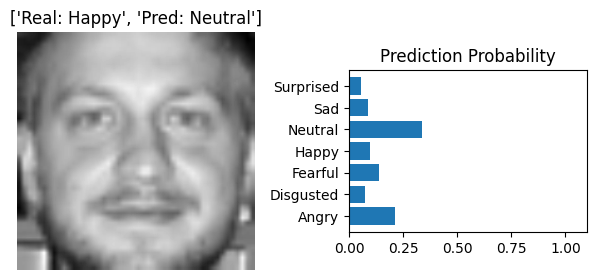

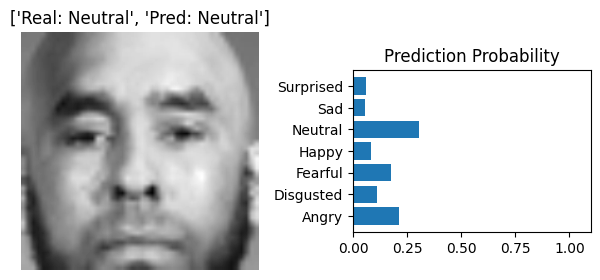

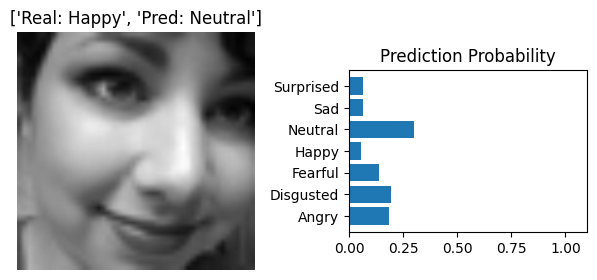

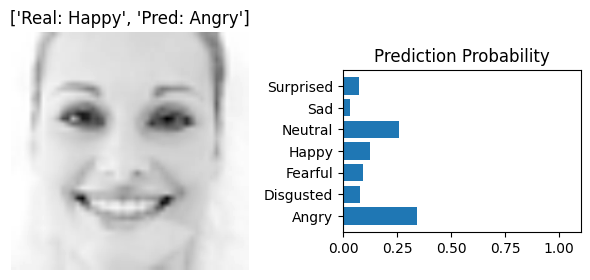

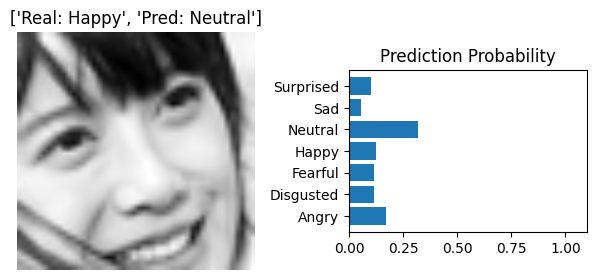

In [87]:
model_resnet_pt.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_resnet_pt(image_batch)
for i in range(30,40):
    img = image_batch[i][0].cpu().detach()
    real_label = f'Real: {label_dict_res[label_batch[i].item()]}'
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    pred_prob = pred_prob/sum(pred_prob)
    visualize_pred(img, pred_prob, real_label, label_dict_res, num_classes, cmap='gray')

#### Performance decrease from 61% for ResNet-18 trained from scratch to 12% for Pretrained ResNet-18